Inspired by https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch/notebook

In [ ]:
!pip install sentence-transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.0 MB/s 
     |████████████████████████████████| 5.5 MB 48.3 MB/s 
     |████████████████████████████████| 1.3 MB 51.0 MB/s 
     |████████████████████████████████| 182 kB 53.9 MB/s 
     |████████████████████████████████| 7.6 MB 48.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=711e3c7c3f24c6480b73140b4da07560d629eb46fa6860b881e9299c66460ff0
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

## Get data

In [ ]:
df_topics = pd.read_csv('gdrive/MyDrive/data_fk/topics.csv', index_col=0)

In [ ]:
df = pd.read_csv('gdrive/MyDrive/data_fk/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

df = df[['assestment']][df.index.isin(df_topics.index)].reset_index(drop=True)

df = pd.concat([df, pd.read_csv('gdrive/MyDrive/data_fk/embeddings_pl_herbert.csv', sep=",", header=None)], axis=1)

In [ ]:
df.shape

(6541, 1025)

In [ ]:
class FakeNews(Dataset):
    def __init__(self, df, train=True):
        self.is_train = train
        
        if self.is_train:            
            self.claims = df.iloc[:, 1:].values
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.claims = df.iloc[:, 1:].values
        
    def __len__(self):
        return len(self.claims)
    
    def __getitem__(self, item):
        anchor_claim = self.claims[item]
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_claim = self.claims[positive_item]
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_claim = self.claims[negative_item]

            anchor_claim = torch.from_numpy(anchor_claim.astype(np.float32))
            positive_claim = torch.from_numpy(positive_claim.astype(np.float32))
            negative_claim = torch.from_numpy(negative_claim.astype(np.float32))

            anchor_label = anchor_label.astype(np.float32)
            
            return anchor_claim, positive_claim, negative_claim, anchor_label
        
        else:
            anchor_claim = torch.from_numpy(anchor_claim)
            return anchor_claim

## Kfold

In [ ]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Train

In [ ]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [ ]:
train_index, test_index = cv_Kfold_i[5]

In [ ]:
train_ds = FakeNews(df.loc[train_index,:].reset_index(drop=True), train=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_ds = FakeNews(df.iloc[test_index, :].reset_index(drop=True), train=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

## TripletLoss

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Network

In [ ]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

JIT -> higher speed?

In [ ]:
model = Network(embedding_dims)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

## Training loop

In [ ]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_claim = anchor_claim.to(device)
        positive_claim = positive_claim.to(device)
        negative_claim = negative_claim.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 1.0237


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.9553


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.9107


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.9020


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.8666


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.8361


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.8215


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.8168


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.7824


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.7682


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.7305


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.6997


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.6752


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.6492


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.6358


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.5850


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.5405


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.5172


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.4861


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.4520


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.4322


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.4056


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.3572


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.3400


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.3056


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.2996


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.2621


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.2487


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.2177


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.2137


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.2041


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.1907


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.2010


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.1743


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.1659


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.1728


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.1565


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.1602


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.1337


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.1384


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.1473


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.1266


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.1262


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.1296


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.1156


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.1260


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0990


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.1101


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.1150


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0952


In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

## Visualise

In [ ]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for claim, _, _, label in tqdm(train_loader):
        train_results.append(model(claim.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/184 [00:00<?, ?it/s]

(5887, 2)

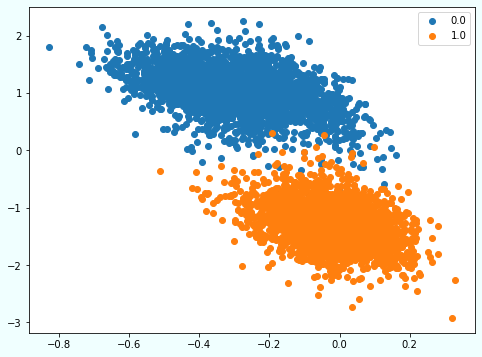

In [ ]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

## Test with logreg

In [ ]:
test_df = df.iloc[test_index, :].reset_index(drop=True)

test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for index, row in tqdm(test_df.iterrows()):
        label = row.values[0]
        claim = row.values[1:]

        test_results.append(model(torch.from_numpy(claim.astype(np.float32)).to(device)).cpu().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)

0it [00:00, ?it/s]

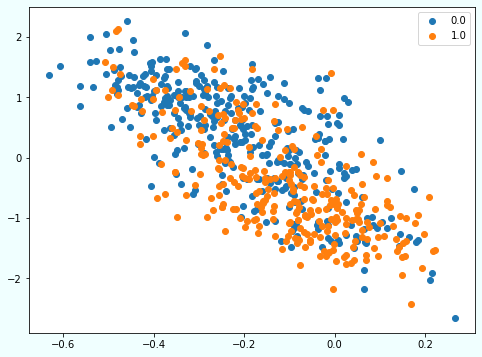

In [ ]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(test_labels):
    tmp = test_results[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [ ]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [ ]:
metrics

{'Accuracy': array([0.69266055]), 'F1 Score': array([0.6655574])}

## Applying it for K split

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

for train_index, test_index in cv_fold_i:
    train_ds = FakeNews(df.loc[train_index,:].reset_index(drop=True), train=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

    test_ds = FakeNews(df.iloc[test_index, :].reset_index(drop=True), train=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)


    model = Network(100)
    model = torch.jit.script(model).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.jit.script(TripletLoss())


    model.train()
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)
            
            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)
            
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.cpu().detach().numpy())

    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            train_results.append(model(claim.to(device)).cpu().numpy())
            labels.append(label)
            
    train_results = np.concatenate(train_results)
    labels = np.concatenate(labels)


    test_df = df.iloc[test_index, :].reset_index(drop=True)

    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for index, row in test_df.iterrows():
            label = row.values[0]
            claim = row.values[1:]

            test_results.append(model(torch.from_numpy(claim.astype(np.float32)).to(device)).cpu().numpy())
            test_labels.append(label)
            
    test_results = np.concatenate(test_results)


    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.671+-0.017 F1 Score 0.650+-0.027  0.671+-0.017 | 0.650+-0.027


In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

for train_index, test_index in cv_Kfold_i:
    train_ds = FakeNews(df.loc[train_index,:].reset_index(drop=True), train=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

    test_ds = FakeNews(df.iloc[test_index, :].reset_index(drop=True), train=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)


    model = Network(100)
    model = torch.jit.script(model).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.jit.script(TripletLoss())


    model.train()
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)
            
            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)
            
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.cpu().detach().numpy())

    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            train_results.append(model(claim.to(device)).cpu().numpy())
            labels.append(label)
            
    train_results = np.concatenate(train_results)
    labels = np.concatenate(labels)


    test_df = df.iloc[test_index, :].reset_index(drop=True)

    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for index, row in test_df.iterrows():
            label = row.values[0]
            claim = row.values[1:]

            test_results.append(model(torch.from_numpy(claim.astype(np.float32)).to(device)).cpu().numpy())
            test_labels.append(label)
            
    test_results = np.concatenate(test_results)


    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    